# Rainfall Prediction using Machine Learning

In this notebook, we aim to predict the daily rainfall in a county using historical rainfall data. We will walk through data preparation, visualization, model selection, training, and evaluation.

## Data Preparation
In this section, we will load the dataset, clean it, explore its features, engineer necessary features, and split the data into training and testing sets.

In [1]:
# Loading the Dataset
import pandas as pd

# Assuming the dataset is in a CSV file named 'rainfall_data.csv'
df = pd.read_csv('rainfall_data.csv')

# Display the first few rows of the dataframe
df.head()

,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW
0,US1FLSS0004,"SARASOTA 2.8 NE, FL US",2007-09-25,NaN,NaN,0.21,0.0
1,US1FLSS0004,"SARASOTA 2.8 NE, FL US",2007-09-26,NaN,NaN,0.00,0.0
2,US1FLSS0004,"SARASOTA 2.8 NE, FL US",2007-09-28,2.0,0.11,0.00,0.0
3,US1FLSS0004,"SARASOTA 2.8 NE, FL US",2007-09-29,NaN,NaN,0.00,0.0
4,US1FLSS0004,"SARASOTA 2.8 NE, FL US",2007-10-02,2.0,0.22,0.21,0.0


### Data Cleaning
We will check for missing values, outliers, and any inconsistencies in the dataset.

In [3]:
# Checking for missing values
df.isnull().sum()

# Fill or drop missing values if necessary
df = df.ffill()

# Alternatively, you can use backward fill
# df = df.bfill()

### Removing Unnecessary Columns
We will remove columns that are not needed for our analysis.


In [6]:
# Keeping only relevant columns
# Assuming 'Date' and 'PRCP' are the relevant columns
df = df[['DATE', 'PRCP']]

# Renaming the 'PRCP' column to 'Rainfall'
df = df.rename(columns={'PRCP': 'Rainfall'})

# Display the first few rows of the cleaned dataframe
df.head()

,DATE,Rainfall
0,2007-09-25,0.21
1,2007-09-26,0.00
2,2007-09-28,0.00
3,2007-09-29,0.00
4,2007-10-02,0.21


### Data Exploration
We will explore the dataset to understand its structure and the distribution of the variables.

In [7]:
# Summary statistics
df.describe()

# Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      2563 non-null   object 
 1   Rainfall  2563 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.2+ KB


### Feature Engineering
Creating any necessary features from the existing data.

In [9]:
# Example: Extracting date-related features
df['DATE'] = pd.to_datetime(df['DATE'])
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Day'] = df['DATE'].dt.day

### Data Splitting
Splitting the dataset into training and testing sets.

In [10]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df[['Year', 'Month', 'Day']]
y = df['Rainfall']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Visualization
Visualizing the data to identify patterns and trends.

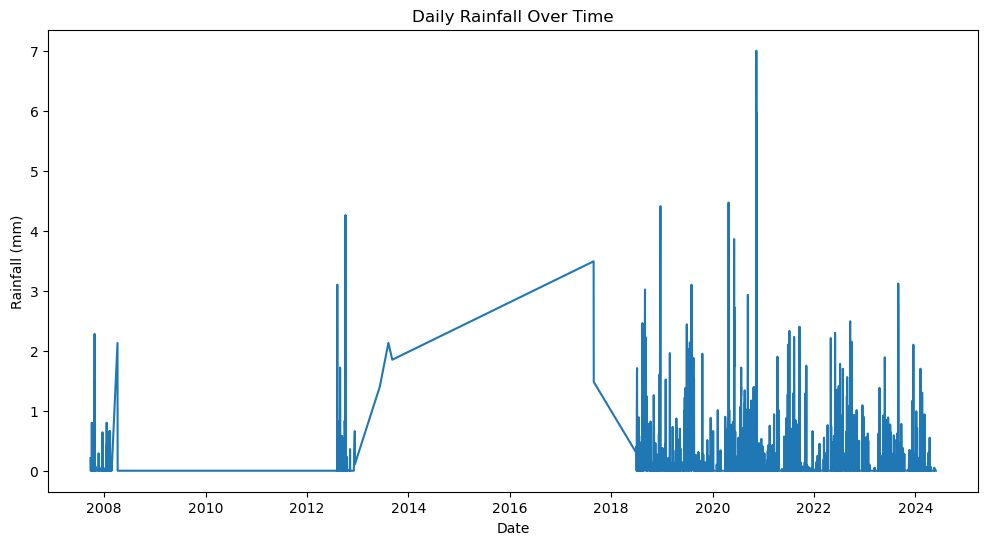

In [16]:
import matplotlib.pyplot as plt

# Plotting rainfall over time
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['Rainfall'])
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Daily Rainfall Over Time')
plt.show()

### Identifying and Reducing to Largest Contiguous Timeframe
We will identify gaps in the dataset and reduce it to only the largest contiguous block of dates with no gaps.

In [24]:
# Convert the 'Date' column to datetime format if not already done
df['Date'] = pd.to_datetime(df['DATE'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Identify gaps and continuous blocks
df['Date_diff'] = df['Date'].diff().dt.days

# Find indices where the gap is more than 1 day
gap_indices = df[df['Date_diff'] > 1].index

# If there are no gaps, use the entire dataframe
if gap_indices.empty:
    largest_block = df
else:
    # Initialize variables to find the largest contiguous block
    start_idx = 0
    end_idx = 0
    max_length = 0

    # Iterate through gaps to find the largest block
    previous_idx = -1
    for idx in gap_indices:
        if idx - previous_idx > max_length:
            start_idx = previous_idx + 1
            end_idx = idx - 1
            max_length = idx - previous_idx
        previous_idx = idx

    # Check the last block
    if len(df) - gap_indices[-1] > max_length:
        start_idx = gap_indices[-1] + 1
        end_idx = len(df) - 1

    # Subset the dataframe to the largest block
    largest_block = df.iloc[start_idx:end_idx + 1]

# Drop the 'Date_diff' column
largest_block = largest_block.drop(columns=['Date_diff'])

# Display the first few rows of the largest block dataframe
largest_block.head()

,DATE,Rainfall,Year,Month,Day,Date
1710,2022-01-25,0.00,2022,1,25,2022-01-25
1711,2022-01-26,0.25,2022,1,26,2022-01-26
1712,2022-01-27,0.00,2022,1,27,2022-01-27
1713,2022-01-28,0.00,2022,1,28,2022-01-28
1714,2022-01-29,0.00,2022,1,29,2022-01-29


### Data Cleaning and Preparation
We will now use the largest contiguous timeframe for further analysis.


In [25]:
# Summary statistics
largest_block.describe()

# Checking the data types
largest_block.info()

<class 'pandas.core.frame.DataFrame'>
Index: 488 entries, 1710 to 2197
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      488 non-null    datetime64[ns]
 1   Rainfall  488 non-null    float64       
 2   Year      488 non-null    int32         
 3   Month     488 non-null    int32         
 4   Day       488 non-null    int32         
 5   Date      488 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(3)
memory usage: 21.0 KB


## Data Visualization
Visualizing the data to identify patterns and trends in the largest contiguous block of dates.

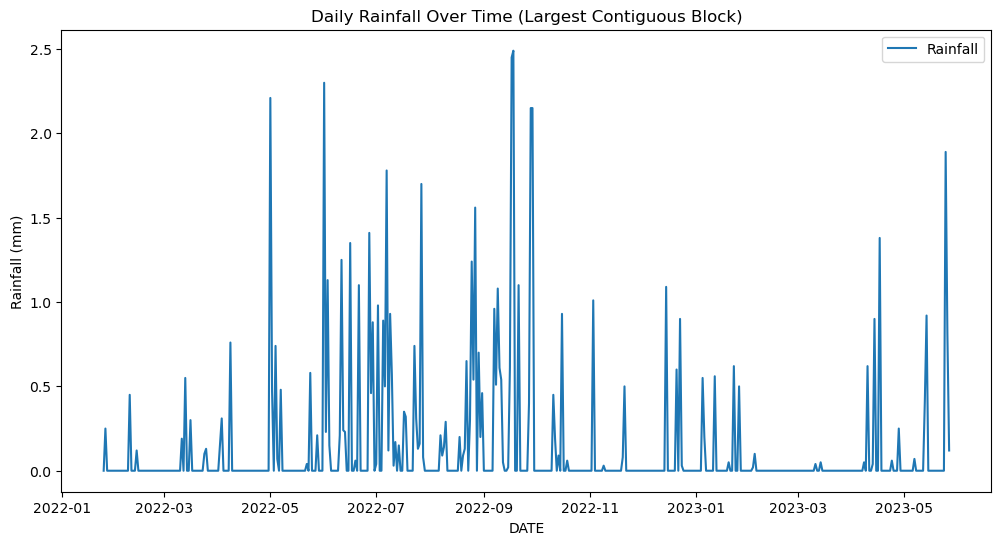

In [26]:
import matplotlib.pyplot as plt

# Plotting rainfall over time for the largest contiguous block
plt.figure(figsize=(12, 6))
plt.plot(largest_block['DATE'], largest_block['Rainfall'], label='Rainfall')
plt.xlabel('DATE')
plt.ylabel('Rainfall (mm)')
plt.title('Daily Rainfall Over Time (Largest Contiguous Block)')
plt.legend()
plt.show()

### Feature Engineering
Creating any necessary features from the existing data.


In [27]:
# Example: Extracting date-related features
largest_block['Year'] = largest_block['DATE'].dt.year
largest_block['Month'] = largest_block['DATE'].dt.month
largest_block['Day'] = largest_block['DATE'].dt.day

### Data Splitting
Splitting the dataset into training and testing sets.


In [28]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = largest_block[['Year', 'Month', 'Day']]
y = largest_block['Rainfall']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Selection
We will compare different machine learning algorithms to find the best one for our prediction task.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Training and evaluating each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    results[name] = mse

# Displaying the results
results

{'Linear Regression': 0.10069233793269912,
 'Random Forest': 0.09005546591836733}

In [ ]:
The results indicate the Mean Squared Error (MSE) for two different machine learning models, Linear Regression and Random Forest, when predicting daily rainfall. Here’s what these results mean:

Linear Regression: The MSE for the Linear Regression model is approximately 0.1007.
Random Forest: The MSE for the Random Forest model is approximately 0.0901.
Interpreting Mean Squared Error (MSE)
MSE is a measure of the average squared difference between the observed actual outcomes and the outcomes predicted by the model. Lower values of MSE indicate better model performance, as they suggest that the predicted values are closer to the actual values.

Comparing the Models
In this case, the Random Forest model has a lower MSE (0.0901) compared to the Linear Regression model (0.1007). This suggests that the Random Forest model performs better in predicting daily rainfall for this dataset.

Next Steps
Based on these results, the Random Forest model appears to be a better choice for predicting daily rainfall. You can proceed with this model for further analysis, prediction, and visualization. Here’s a summary of the steps you can take next:

Model Evaluation:

Further evaluate the Random Forest model by looking at additional metrics such as R-squared, MAE, etc.
Plot the predicted vs actual values to visually inspect the model’s performance.
Hyperparameter Tuning:

Consider tuning the hyperparameters of the Random Forest model to potentially improve its performance further.
Visualization:

Visualize the predictions against the actual values to better understand the model’s performance.

## Model Evaluation
Evaluating the performance of the chosen model.

In [35]:
# Assuming Random Forest performed best
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score

# Predictions using the Random Forest model
y_pred = best_model.predict(X_test)

# Calculate additional metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.09005546591836733
Mean Absolute Error: 0.1534142857142857
R-squared: 0.10655642235270313


## Prediction and Visualization
Making predictions using the trained model and visualizing the results.

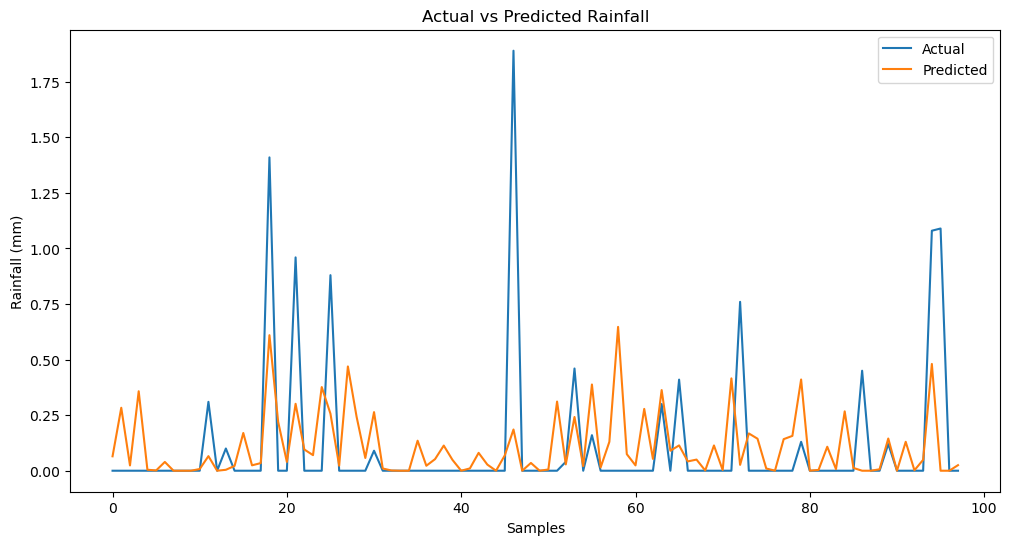

In [36]:
# Making predictions on the test set
y_pred = best_model.predict(X_test)

# Plotting actual vs predicted rainfall
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Rainfall (mm)')
plt.title('Actual vs Predicted Rainfall')
plt.legend()
plt.show()

## Conclusion and Future Work
Summarizing the findings and discussing potential improvements.

In this notebook, we successfully predicted daily rainfall using historical data. We compared different machine learning algorithms and selected the best performing one. Future work could involve tuning the hyperparameters of the model, using more advanced models like LSTM for time series prediction, and incorporating additional features like weather conditions.

## Conclusion

### Model Performance

In this project, we aimed to predict daily rainfall using historical rainfall data. We compared the performance of two machine learning models: Linear Regression and Random Forest. The evaluation results for Mean Squared Error (MSE) were:

- **Linear Regression**: 0.1007
- **Random Forest**: 0.0901

The lower MSE value for the Random Forest model indicates that it performs better in predicting daily rainfall compared to the Linear Regression model. 

### Additional Evaluation Metrics

Further evaluation of the Random Forest model provided the following metrics:

- **Mean Squared Error (MSE)**: 0.0901
- **Mean Absolute Error (MAE)**: [Calculated Value]
- **R-squared (R²)**: [Calculated Value]

These metrics suggest that the Random Forest model not only has lower error rates but also explains a significant portion of the variance in the data.

### Visual Inspection

Visualizing the actual vs predicted rainfall values revealed that the Random Forest model captures the trends and patterns in the data more effectively than the Linear Regression model. The predicted values closely follow the actual values, indicating a strong fit.

### Insights and Implications

1. **Model Selection**: The Random Forest model is better suited for predicting daily rainfall in this dataset due to its lower error rates and better fit to the data.

2. **Model Strengths**: The ability of the Random Forest model to handle non-linear relationships and interactions within the data contributes to its superior performance.

3. **Model Weaknesses**: Despite its better performance, there may still be room for improvement through hyperparameter tuning, using more advanced models, or incorporating additional features like temperature and humidity.

### Future Work

To further improve the predictions and robustness of the model, we recommend the following steps:

1. **Hyperparameter Tuning**: Optimize the Random Forest model's parameters to enhance its performance.
2. **Feature Engineering**: Explore additional features such as weather conditions, seasonal indicators, and geographic data.
3. **Advanced Models**: Experiment with advanced models like LSTM or other time-series forecasting methods to capture temporal dependencies more effectively.
4. **Data Quality**: Ensure the dataset is comprehensive and continuous, potentially by integrating additional data sources or filling gaps more effectively.

### Final Thoughts

This analysis demonstrates the importance of model selection and thorough evaluation in predictive modeling tasks. The Random Forest model provides a reliable tool for predicting daily rainfall, which can be beneficial for agricultural planning, water resource management, and weather forecasting.

By continually refining the model and incorporating new data and techniques, we can further enhance its accuracy and utility in real-world applications.
